# Minnesota potential

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid
from RseSolver import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *

## Warm up: solve Schrödinger equation using Runge Kutta

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
# lvalues = [0]
# channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

l = 2
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
# rmin = np.min((0.1, (factorial2(2*l+1) * 1e-4)**(1/(l+1)) / scattExp.p))
rmin = 1e-12 
assert rmin < 1, "rmin > 1"
# print(f"rmin: {rmin}")
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

In [10]:
inhomogeneous=False
scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="Numerov", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)
scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="RK45", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)

# plt.plot(grid.points, np.real(scattSols_rk45[0].u), label="RK45")
# plt.plot(grid.points, np.real(scattSols_numerov[0].u), label="Numerov")
pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
# plt.plot(grid.points, spherical_jn(l, pr) * pr, ls=":", label="exact")
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="diff")
# plt.plot(grid.points, 
#          np.real(scattSols_numerov[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact Numerov")
# plt.plot(grid.points, 
#          np.real(scattSols_rk45[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact RK")
plt.xlabel("$r$")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
plt.title(f"$\ell = {l}$")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phaseshifts", a,b, np.abs(a-b))

TypeError: RseSolver.solve() got an unexpected keyword argument 'inhomogeneous'

In [ ]:
inhomogeneous=True
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing


TypeError: RseSolver.solve() got an unexpected keyword argument 'lecList_dict'

In [68]:
solver.solve(lecList_dict=testingLecList, method="Numerov_affine", reduced_output=True, **args)[1]

array([0.12807611])

In [77]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


1.1102230246251565e-16

In [13]:
inhomogeneous=True
args = dict(lecList=testingLecList, asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(method="Numerov_affine", **args)
num2  = solver.solve(method="Numerov", **args)
numk  = solver.solve(method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 1.202926647181357e-13
diff 1.4836676331952958e-10


1.1102230246251565e-16

testing


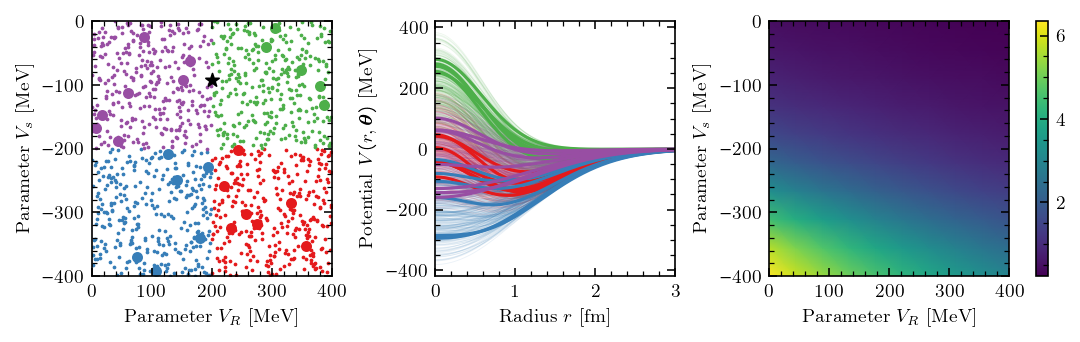

In [10]:
cm = 1./2.54
from constants import hbarc
fig, axs = plt.subplots(1,3, figsize=(18*cm,5.5*cm), constrained_layout=True)

for index, n in enumerate((1250, 25)):
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.4, 1.5][index]
    alpha_lines = (0.1, 1.)[index]
        
    grid_plot = np.linspace(0, 4, 200)

    color = colors[0]
    mask = np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] < -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[1]
    mask = np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] < -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[2]
    mask = np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] > -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)

    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)

    color = colors[3]
    mask = np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] > -200)
    axs[0].scatter(param_samples_plot[mask,0], param_samples_plot[mask,1], color=color, s=size_marker)
    
    for ilec, lec_sample in enumerate(param_samples_all):
        if not mask[ilec]: 
            continue 
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines)
        
axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")

solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=True)
# num1  = solver.solve(lecList_=testingLecList, method="Numerov_affine", **args)

num_theta1 = 10
num_theta2 = 10
theta1 = np.linspace(0, 400, num_theta1)
theta2 = np.linspace(-400, 0, num_theta2)
min_sv = np.zeros((num_theta2, num_theta1))
# cond = np.zeros((num_theta2, num_theta1))
import scipy.linalg as spla
for j, t1 in enumerate(theta1):
    for i, t2 in enumerate(theta2):
        theta_vec = np.array([1, t1, t2])
        A_theta_vec, _ = solver.numerov_solver.get_linear_system(theta_vec, ret_diag_form=False, file_dump=False)
        s_theta_vec = spla.svdvals(A_theta_vec)
        min_sv[i, j] = s_theta_vec[-1] * 1e7
        # cond[i, j] = s_theta_vec[0] / s_theta_vec[-1]

out = axs[2].pcolormesh(theta1, theta2, min_sv, shading='gouraud')
axs[2].set_xlabel("Parameter $V_R$ [MeV]")
axs[2].set_ylabel("Parameter $V_s$ [MeV]")
axs[2].set_xlim(0,400)
axs[2].set_ylim(-400,0)
_ = fig.colorbar(out)
fig.savefig("minnesota_parameter_space_partition_sval.png", dpi=200)

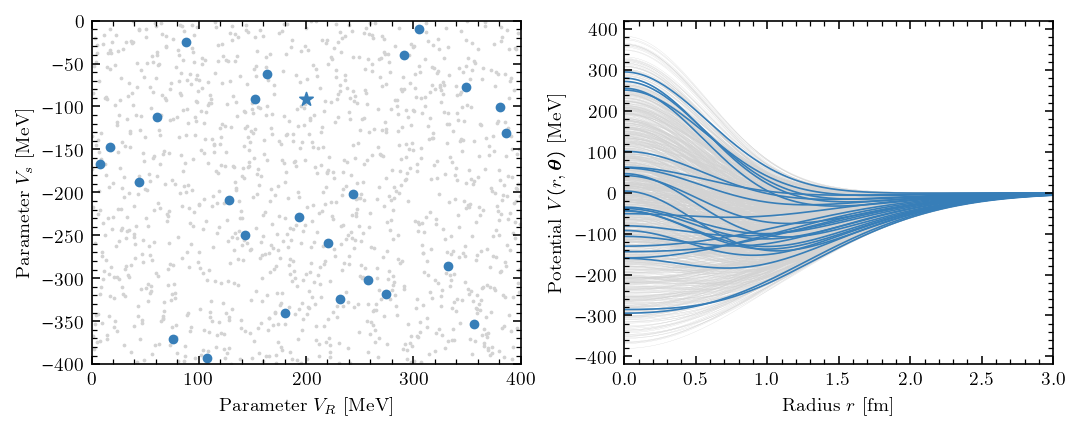

In [127]:
cm = 1./2.54
from constants import hbarc
fig, axs = plt.subplots(1,2, figsize=(18*cm,7*cm), constrained_layout=True)

for index, n in enumerate((1250, 25)):
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size)
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color=color, s=45, marker="*")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
fig.savefig("minnesota_parameter_space.png", dpi=200)

In [33]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


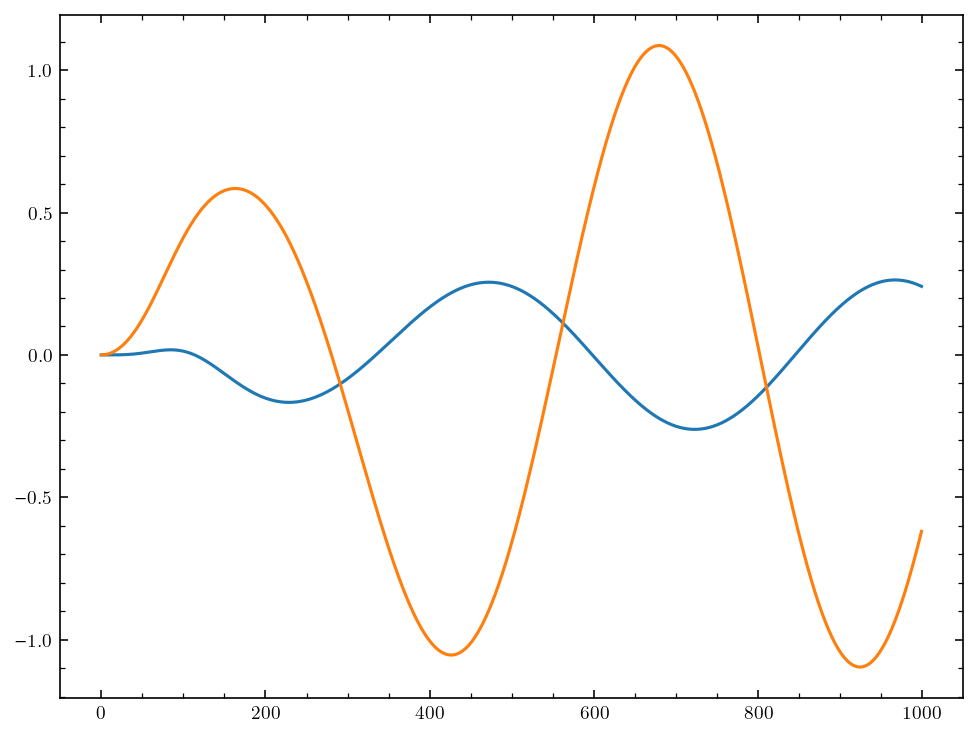

In [ ]:
plt.plot(num1[0].chiprime)
plt.plot(num1[0].uprime)

In [ ]:
ab = np.loadtxt("orig_ab.csv")
rhs = np.loadtxt("orig_s.csv")
A = np.loadtxt("class_A.csv")
s = np.loadtxt("class_s.csv")
print(np.max(np.abs(A-ab)))
print(np.max(np.abs(s-rhs)))

4.440892098500626e-16
5.551115123125783e-17


In [ ]:
from Numerov import diag_ord_form_to_mat
np.linalg.cond(diag_ord_form_to_mat(A, (2,0), toarray=True)[1:,1:])

367172.8170310892

In [ ]:
# np.abs(num[0].u-num2[0].u)#

In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ngrid, ngrid, ntheta))

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit np.tensordot(X.T, np.tensordot(At, X, axes=[1,0]), axes=[1,0]).shape

Xshape (1000, 5)
Atshape (1000, 1000, 10)
37.8 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ntheta, ngrid, ngrid))
lec = np.ones(ntheta)

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit (X.T @ At @ X).shape
np.tensordot(lec, (X.T @ At @ X), axes=1).shape

Xshape (1000, 5)
Atshape (10, 1000, 1000)
4.8 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(5, 5)

## Benchmark Numerov

In [ ]:
def f(E_MeV, channel, inhomogeneous=True):
    potentialArgs = {"label": "chiral", "kwargs": {"potId": 213}}
    potential = Potential(channel, **potentialArgs)
    trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

    grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
                type="linear", test=False) 
    scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="Numerov", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                                method="RK45", inhomogeneous=inhomogeneous,
                                asympParam="K", matching=True)
    return [scattSols_numerov[0],
            scattSols_rk45[0]]  # Lmatrix.phaseShift

In [ ]:
lvalues = [0, 1, 2, 3, 4]
energies_MeV = [10.0,
20.0,
25.0,
50.0,
100.0]

for l in lvalues:
    channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
    for E_MeV in energies_MeV:
        res = f(E_MeV, channel, inhomogeneous=True)
        res = [res[0].Lmatrix.phaseShift, res[1].Lmatrix.phaseShift]
        # print(f"l = {l} | E = {E_MeV} | {np.real(res)[0]}") 
        # print(f"{np.real(res)[0]}") 
        print(f"{np.abs(res[0]-res[1])}") 
    print()


7.691034653589668e-08
6.721351297755973e-08
6.648935624298247e-08
8.224466441220102e-08
1.7840128840873604e-07

9.63403579135047e-10
3.902020040413845e-09
6.2748686247005026e-09
3.1421905077877454e-08
1.5629652949655792e-07

1.8845147664592332e-11
3.136362280997673e-10
5.669067437708009e-10
4.316599522269371e-09
2.523817954624974e-08

1.2856382625159313e-11
3.129586589878386e-10
9.600933381648247e-10
8.462230027816986e-09
5.70108906750022e-08

8.677291524206154e-11
2.787643726964717e-11
3.576594576060188e-11
1.1687456002995589e-09
1.2410865224410372e-08



working on 1S0
working on 1P1
working on 1D2
working on 1F3
working on 1G4


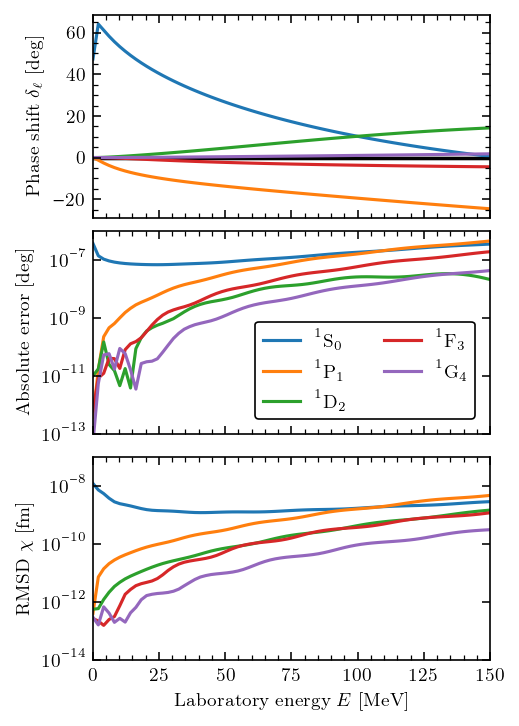

In [ ]:
# %pip install pandas
import pandas as pd
lvalues = [0, 1, 2, 3, 4] # , 8] # , 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 
cm = 1./2.54
energies_MeV = np.linspace(1e-1, 150, 75)
fig, axs = plt.subplots(3,1, sharex=True, figsize=(8.5*cm,12*cm), constrained_layout=True)

for channel in channels:
    print("working on", channel.spectNotation)
    ret_raw = []
    for E_MeV in energies_MeV:
        ret_raw.append(f(E_MeV=E_MeV, channel=channel))

    ret = np.array([[elem[0].Lmatrix.phaseShift, elem[1].Lmatrix.phaseShift] for elem in ret_raw])
    df = pd.DataFrame(data={"Energies": energies_MeV,
                            "Numerov": ret[:,0], 
                            "RK45": ret[:,1]})
    df.to_csv(f"phase_shifts_chiral_{channel.spectNotation}")

    axs[0].plot(energies_MeV, np.real(ret[:,0]))
    axs[0].set_ylabel("Phase shift $\delta_\ell$ [deg]")
    # axs[0].set_xlabel("Lab Energy $E$ [MeV]")
    axs[0].axhline(0, color = "k", zorder=0)
    # axs[0].axes.get_xaxis().set_visible(False)

    axs[1].plot(energies_MeV, np.abs(ret[:,0]-ret[:,1]), label=channel.spectNotationTeX)
    axs[1].set_yscale('log')
    axs[1].set_ylim(bottom=1e-13, top=1e-6)
    axs[1].set_xlim(left=0, right=150)
    axs[1].set_ylabel("Absolute error [deg]") #  $\Delta \delta_\ell$ [deg]")
    # axs[1].set_xlabel("Laboratory energy $E$ [MeV]")
    axs[1].legend(ncol=2) # title="$\ell = $"

    rms_error = [np.linalg.norm((elem[0].u - elem[1].u))/ np.sqrt(len(elem[0].u)) for elem in ret_raw ]
    axs[2].plot(energies_MeV, rms_error, label=channel.spectNotationTeX)
    axs[2].set_yscale('log')
    axs[2].set_ylim(bottom=1e-14, top=1e-7)
    axs[2].set_xlim(left=0, right=150)
    axs[2].set_ylabel("RMSD $\chi_\ell$ [fm]")
    axs[2].set_xlabel("Laboratory energy $E$ [MeV]")
    # axs[2].legend(ncol=2) # title="$\ell = $"
fig.savefig("benchmark.pdf")

## Figure

In [ ]:
from NumerovEmulator import AffineGROMNoMatch
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": (-400, 0)}, 
            num_snapshots_init=2, 
            num_snapshots_max=200, 
            approach="greedy", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            seed=10203
            )
greedy_grom = AffineGROMNoMatch(emulator_training_mode="grom", **args)
greedy_lspg = AffineGROMNoMatch(emulator_training_mode="lspg", **args)

POD[ Y ]: compression rate is 33.3 %; dim: (800, 6)
snapshot idx already included in basis: {35, 149}
now greedily improving the snapshot basis:
	iteration #1 of max 3:
	available candidate snapshot idx to be added: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


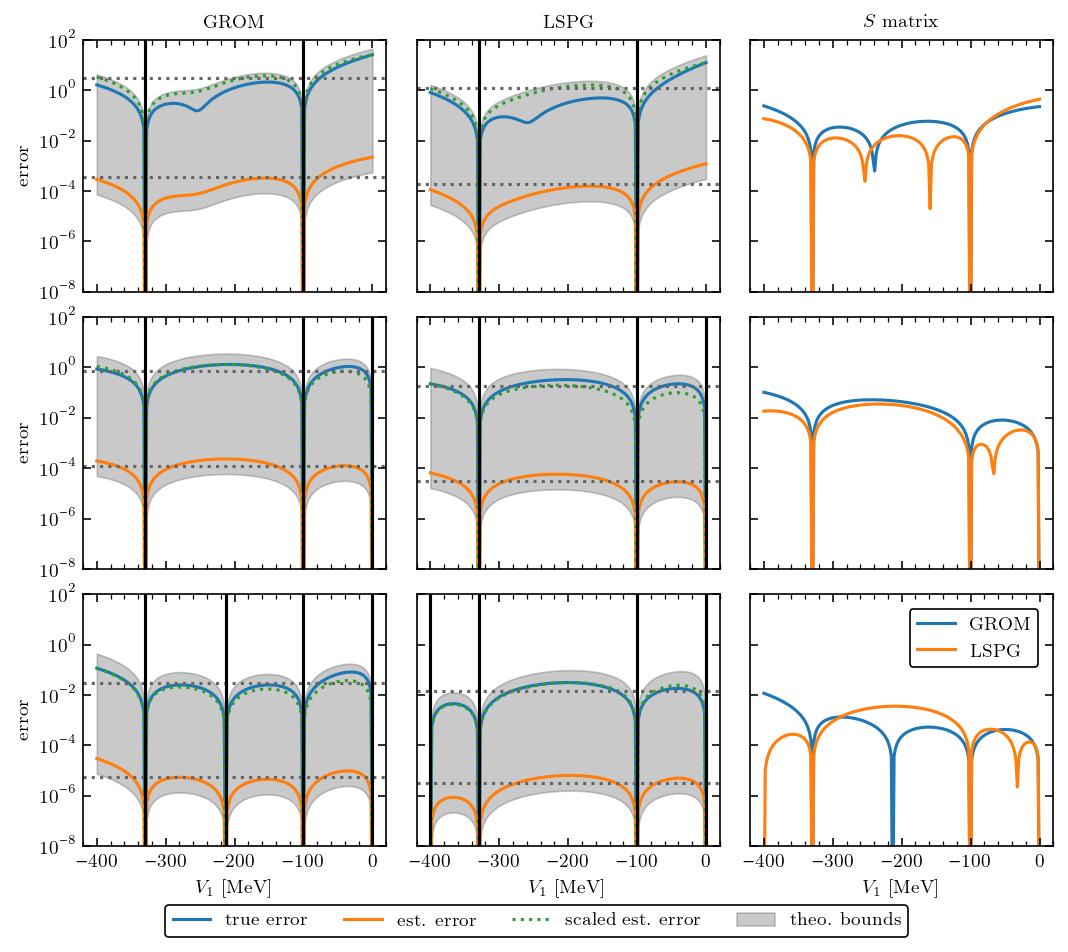

In [ ]:
from constants import cm
mpl.rcParams['figure.constrained_layout.use'] = False
num_iter = len(greedy_lspg.greedy_logging)
V0_arr = greedy_lspg.lec_all_samples[:,2]
fig, axs = plt.subplots(num_iter, 3, sharex=True, sharey=True,
                        figsize=(18*cm,16*cm), layout=None)

plt.subplots_adjust(left=0.07, right=0.99, 
                    top=0.96, bottom=0.1, 
                    wspace=0.1, hspace=0.1)
for ax in axs[-1,:]:
    ax.set_xlabel("$V_1$ [MeV]")
for ax in axs[:, 0]:
    ax.set_ylabel("error")
for ax, title in zip(axs[0,:], ("GROM", "LSPG", "$S$ matrix")):
    ax.set_title(title)

axs[0,0].set_ylim(1e-8, 1e2)
# axs[0,0].set_xlim(V0_arr[0], V0_arr[-1])

for niter in range(num_iter):
    for irom_lbl, rom_lbl in enumerate(("grom", "lspg")):
        rom = greedy_grom if rom_lbl == "grom" else greedy_lspg
        ax = axs[niter, irom_lbl]
        [snapshot_idxs, fom_sol, emulated_sol, 
        romErrors, realErrors, estErrBounds,
        coercivity_constant] = rom.greedy_logging[niter]
        ax.semilogy(V0_arr, realErrors, label=f"true error")
        ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
        ax.semilogy(V0_arr, coercivity_constant*romErrors, 
                    ls=":", label=f"scaled est. error")
        
        # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
        # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
        ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                        alpha=0.3, color='0.3',
                        zorder=0, label="theo. bounds")

        Smats_emul = greedy_lspg.get_S_matrix(emulated_sol)
        Smats_fom = greedy_lspg.get_S_matrix(fom_sol)
        axs[niter, 2].semilogy(V0_arr, np.abs(Smats_emul - Smats_fom), label=rom_lbl.upper())
        # ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
    
        for err in (romErrors, realErrors):
            ax.axhline(np.mean(err), ls=":", c='0.4', label="")
            # ax.set_title(f"Estimated mean error: {np.mean(realErrors):.2e}")

        for idx in snapshot_idxs:
            ax.axvline(V0_arr[idx], c="k", label="")
    
    axs[-1,0].legend(bbox_to_anchor =(0.5, 0.02), loc='center', ncol=4, 
                     bbox_transform=fig.transFigure)
    # axs[0,0].legend(loc='lower left', ncol=4, bbox_to_anchor =(1.5,2.65))
    axs[-1,-1].legend(loc='best', ncol=1)
    fig.savefig(f"greedy_MN_potential_1S0.pdf")